In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import accuracy, error_rate

In [2]:
image_path = Path('../image-data/01-single-rgb/')
image_path.ls()

[PosixPath('../image-data/01-single-rgb/high'),
 PosixPath('../image-data/01-single-rgb/medium'),
 PosixPath('../image-data/01-single-rgb/models'),
 PosixPath('../image-data/01-single-rgb/low')]

In [3]:
image_size = 256
batch_size = 64
tfms = get_transforms()

In [4]:
data = (ImageList.from_folder(image_path)
       .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=image_size)
       .databunch(bs=batch_size)
       .normalize()) # Optional

In [5]:
data

ImageDataBunch;

Train: LabelList (9418 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
high,high,high,high,high
Path: ../image-data/01-single-rgb;

Valid: LabelList (2354 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
high,high,medium,high,high
Path: ../image-data/01-single-rgb;

Test: None

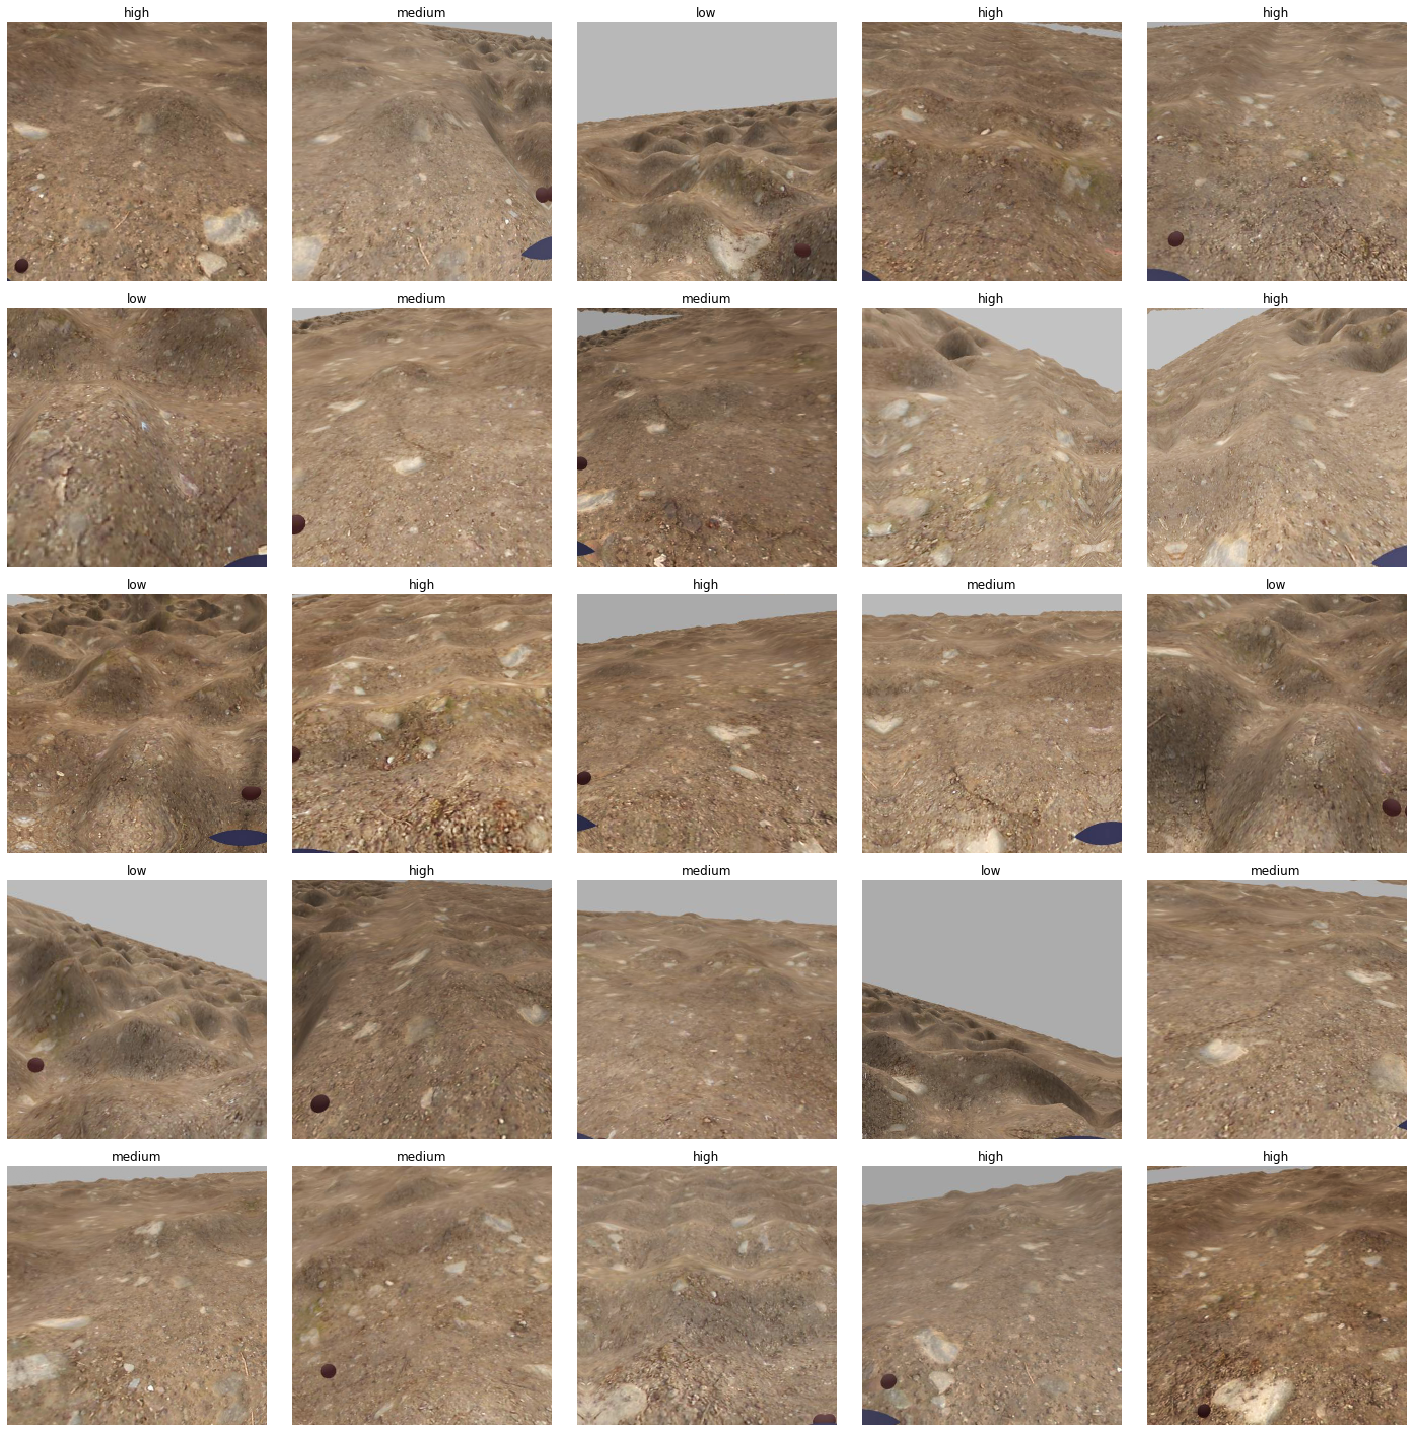

In [6]:
data.show_batch()

In [7]:
data.classes, data.c

(['high', 'low', 'medium'], 3)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], pretrained=False, callback_fns=ShowGraph)
# learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])
# pretrained gave lower accuracy

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

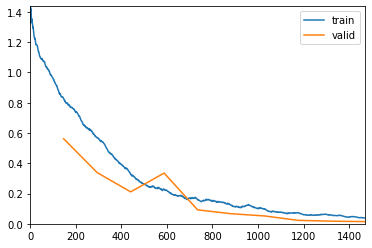

In [10]:
learn.fit_one_cycle(10)

In [16]:
learn.save('stage1-single-rgb')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

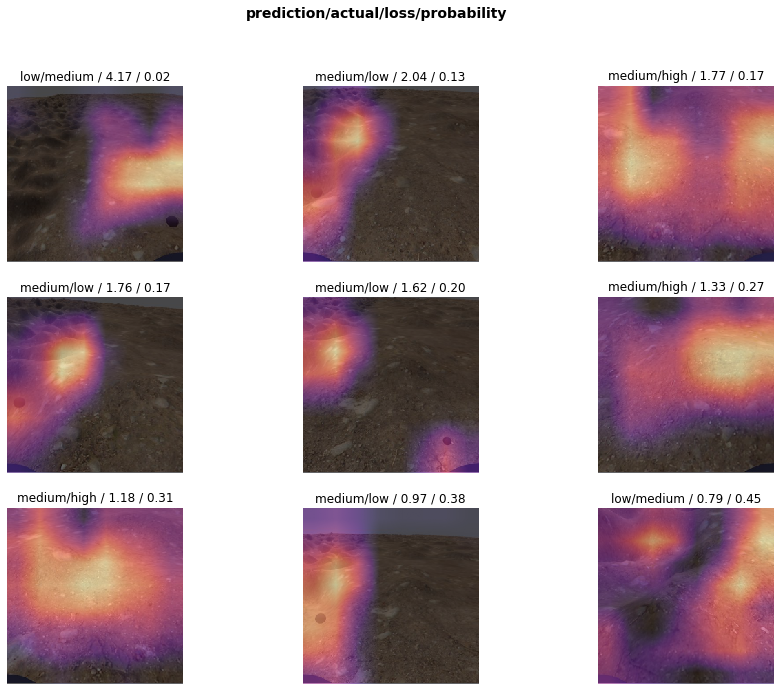

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

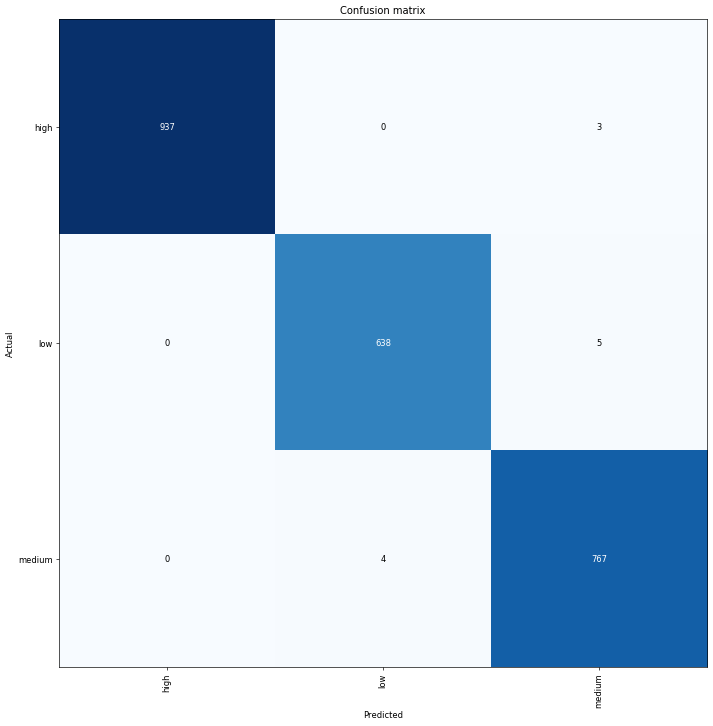

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


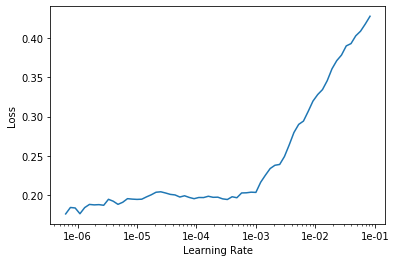

In [25]:
learn.recorder.plot()

In [9]:
from time import time

learn.load('stage1-single-rgb')
learn.model.training = False
# learn.model.cpu() <-- causes error but it should not

grass_path = Path('../image-data/grass/1-rgb')
# grass_path = Path('../image-data/01-single-rgb/')

grass_path.ls()

[PosixPath('../image-data/grass/1-rgb/high'),
 PosixPath('../image-data/grass/1-rgb/medium'),
 PosixPath('../image-data/grass/1-rgb/low')]

In [10]:
# Doing this in a loop to get running times

clsses = ['high', 'medium', 'low']
totals = [0, 0, 0]
correct = [0, 0, 0]

total_time = 0

for clss_idx, clss in enumerate(clsses):
    grass_fnames = grass_path/clss
    print(grass_fnames)
    for grass_fname in grass_fnames.glob('**/*.jpg'):
        
        img = open_image(grass_fname)
        
        tstart = time()
        pred = learn.predict(img)
        total_time += time() - tstart
        
        if str(pred[0]) == clss:
            correct[clss_idx] += 1
        totals[clss_idx] += 1
print('done')

../image-data/grass/1-rgb/high
../image-data/grass/1-rgb/medium
../image-data/grass/1-rgb/low


In [11]:
print(correct)
print(totals)
print([c/t*100 for c, t in zip(correct, totals)])
print(sum(correct)/sum(totals)*100)
print(total_time)

[0, 0, 590]
[568, 590, 590]
[0.0, 0.0, 100.0]
33.75286041189931
12.330504655838013
